
# Fine Tuning



Objectif : utiliser un réseau pré entraîné et une technique de Fine Tuning pour apprendre une classification de données personnelles. Les données étant en nombre insuffisant, une technique d'augmentation de données sera utilisée.

## Imports

In [55]:
import tensorflow as tf
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint


In [2]:
# Paramètres
image_shape = (224, 224, 3)
image_size = image_shape[:2]

batch_size = 32
num_classes = 5


## Données

In [77]:
def Data():
    data_dir = get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                        fname='flower_photos',
                        cache_dir = '/Users/vibarra/Documents/Cours/ISIMA/DeepLearning/TPPython/data',
                        untar=True)

    data_dir = pathlib.Path(data_dir)



    print("Nombre d'images :", len(list(data_dir.glob('*/*.jpg'))))

    classes = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
    print("Classes : ",classes)

    # Augmentation de données : 75% entraînement, 25% test
    image_gen = ImageDataGenerator(rescale = 1/255,validation_split = 0.25)

    # Augmentation de la base d'entraînement
    train_data_gen = image_gen.flow_from_directory(directory = str(data_dir),shuffle = True,classes = list(classes),target_size = image_size, batch_size = batch_size,subset = "training")

    # Augmentation de la base de test/validation
    test_data_gen = image_gen.flow_from_directory(directory = str(data_dir),shuffle = True,classes = list(classes),target_size = image_size,batch_size = batch_size,subset = "validation")

    return train_data_gen, test_data_gen, classes

# Appel de la fonction



In [78]:
def TransferModel(input_shape,stop_freeze):

    pretrained_model = MobileNetV2(input_shape = input_shape)

    # On ôte la dernière couche de classification
    pretrained_model.layers.pop()

    # On fige tous les poids sauf ceux des stop_freeze dernières couches
    for layer in pretrained_model.layers[:-stop_freeze]:
      layer.trainable = False

    d10 = Dense(num_classes, activation = "softmax" )
    # On rajoute en bout de réseau notre couche de classification pour le problème
    model = tf.keras.Sequential([pretrained_model,Flatten(),d10])
    return model


## Réseau

In [90]:
# Chargement des données augmentées
x_train, x_test, classes = Data()
print(x_train)
print( x_test)

Nombre d'images : 3670
Classes :  ['tulips' 'dandelion' 'daisy' 'roses' 'sunflowers']
Found 2755 images belonging to 5 classes.
Found 915 images belonging to 5 classes.


In [83]:
num_epochs = 10
stop_freeze = 4



# Modèle
model = TransferModel(input_shape=image_shape,stop_freeze = stop_freeze)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


# Callback pour la sauvegarde du meilleur modèle
if not os.path.isdir("sauve"):
    os.mkdir("sauve")

checkpoint = ModelCheckpoint("sauve/MobileNetV2_flowers-loss-{val_loss:.2f}-acc-{accuracy:.2f}.h5",
                                save_best_only=True,verbose=1)

train_steps_epoch = np.ceil(x_train.samples / batch_size)
val_steps_epoch = np.ceil(x_test.samples / batch_size)

# Entraînement
model.fit(x_train, steps_per_epoch=train_steps_epoch,
                        validation_data=x_test, validation_steps=val_steps_epoch,
                        epochs=num_epochs, verbose=1, callbacks=[checkpoint])

Nombre d'images : 3670
Classes :  ['tulips' 'dandelion' 'daisy' 'roses' 'sunflowers']
Found 2755 images belonging to 5 classes.
Found 915 images belonging to 5 classes.
Epoch 1/10
87/87 [==============================] - ETA: 0s - loss: 1.5281 - accuracy: 0.7169
Epoch 1: val_loss improved from inf to 1.46409, saving model to sauve/MobileNetV2_flowers-loss-1.46-acc-0.72.h5
87/87 [==============================] - 19s 171ms/step - loss: 1.5281 - accuracy: 0.7169 - val_loss: 1.4641 - val_accuracy: 0.7399
Epoch 2/10
87/87 [==============================] - ETA: 0s - loss: 1.3723 - accuracy: 0.8392
Epoch 2: val_loss improved from 1.46409 to 1.31966, saving model to sauve/MobileNetV2_flowers-loss-1.32-acc-0.84.h5
87/87 [==============================] - 11s 127ms/step - loss: 1.3723 - accuracy: 0.8392 - val_loss: 1.3197 - val_accuracy: 0.8219
Epoch 3/10
87/87 [==============================] - ETA: 0s - loss: 1.2423 - accuracy: 0.8668
Epoch 3: val_loss improved from 1.31966 to 1.21613, savin

In [84]:
# Evaluation du modèle
evaluation = model.evaluate(x_test, steps=val_steps_epoch, verbose=1)
print("Perte = {0:5.3f}, Précision = {1:5.3f}".format(evaluation[0], evaluation[1]))

29/29 [==============================] - 3s 112ms/step - loss: 0.7534 - accuracy: 0.8732
Perte = 0.753, Précision = 0.873


1/1 [==============================] - 1s 1s/step


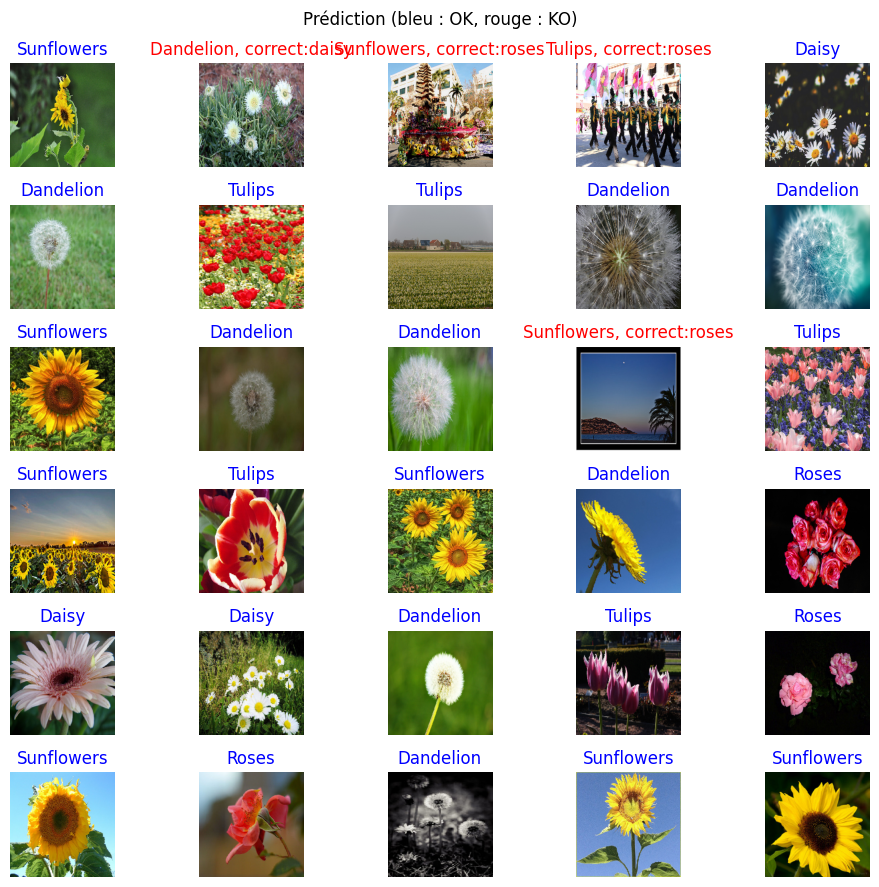

In [80]:
# Quelques exemples de bonne / mauvaise classification
image_batch, label_batch = next(iter(x_test))

label_batch = [classes[np.argmax(label_batch[i])] for i in range(batch_size)]
predicted_classes = model.predict(image_batch)

predicted_ids = [np.argmax(predicted_classes[i]) for i in range(batch_size)]
predicted_classes = np.array([classes[id] for id in predicted_ids])

plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    if predicted_classes[n] == label_batch[n]:
        color = "blue"
        title = predicted_classes[n].title()
    else:
        color = "red"
        title = f"{predicted_classes[n].title()}, correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Prédiction (bleu : OK, rouge : KO)")
plt.tight_layout()
plt.savefig("res.png",dpi=100)